# Background

In this project, we will be exploring how Trump tweets. What does he often tweet about? What types of tweets from Trump tended to lead to high engagement? What about his language style?

## How to retrieve the twitter data?

In [2]:
import requests
import json
import pandas as pd

In [3]:
# we will use trumptwitterarchive.com which contains all his tweets since 2009
def get_tweets(year):
    url = ('http://www.trumptwitterarchive.com/data/realdonaldtrump/%s.json' %year)
    r = requests.get(url)
    print(str(year) + ' ' + 'finished.')
    return r.json()

In [4]:
def save_tweets(years=range(2009,2020)):
    tweets = []
    
    for year in years:
        data = get_tweets(year)
        data_length = len(data)
            
        i = 0
        while i < data_length:
            tweets.append(data[i])
            i = i + 1 
                
    return tweets

In [5]:
with open("trump_tweets.json", "w") as outfile:
    json.dump(save_tweets(), outfile)
    print('Done')

2009 finished.
2010 finished.
2011 finished.
2012 finished.
2013 finished.
2014 finished.
2015 finished.
2016 finished.
2017 finished.
2018 finished.
2019 finished.
Done


In [6]:
# take a look at the data frame
df = pd.read_json("trump_tweets.json")
df.shape 
print(df)

                   source               id_str  \
0      Twitter Web Client           6971079756   
1      Twitter Web Client           6312794445   
2      Twitter Web Client           6090839867   
3      Twitter Web Client           5775731054   
4      Twitter Web Client           5364614040   
...                   ...                  ...   
44120  Twitter for iPhone  1080084113762197504   
44121  Twitter for iPhone  1079920504268562432   
44122  Twitter for iPhone  1079906462753869824   
44123  Twitter for iPhone  1079902957938925568   
44124  Twitter for iPhone  1079900120047603712   

                                                    text  \
0      From Donald Trump: Wishing everyone a wonderfu...   
1      Trump International Tower in Chicago ranked 6t...   
2      Wishing you and yours a very Happy and Bountif...   
3      Donald Trump Partners with TV1 on New Reality ...   
4      --Work has begun, ahead of schedule, to build ...   
...                                    

## How to clean the data? 

In [7]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()

def tokenize_tweets(data):
    text = ''
    for token in df['text']:
        text = text + token
    tokens = [i.lower() for i in tk.tokenize(text)]
    return tokens

tokens = tokenize_tweets(df)
print(len(tokens))

1024703


In [8]:
# remove stop words, special characters and links 
from nltk.corpus import stopwords
import string
punctiuation = list(string.punctuation)
stop = stopwords.words('english') + punctiuation

In [9]:
def complete_tokens(tokens):
    tokens_complete = [t for t in tokens 
                       if (len(t) >= 3) 
                       and (not t.startswith(('#', '@'))) # pass hashtag and username
                       and (not t.startswith('http')) # pass links 
                       and (t not in stop) # pass stop words
                       and (t[0].isalpha())] # make sure all characters are alphabets
    
    return tokens_complete

tokens_clean = complete_tokens(tokens)
print(len(tokens_clean))

412770


## What does he often tweet about?

### Let's take a look at the hashtags first

In [10]:
from nltk import FreqDist
hashtags = [t for t in tokens if (t.startswith('#') and len(t) != 1)]
hashtags_freq = FreqDist(hashtags).most_common(10)
print(hashtags_freq)
# it looks like the topics are mostly about promoting his campaign

[('#trump2016', 869), ('#makeamericagreatagain', 519), ('#maga', 267), ('#celebapprentice', 221), ('#celebrityapprentice', 149), ('#trump', 117), ('#americafirst', 102), ('#draintheswamp', 78), ('#trumpforpresident', 76), ('#votetrump', 73)]


### What about the most mentioned users?

In [11]:
users_freq = FreqDist([t for t in tokens if t.startswith("@")]).most_common(10)
print(users_freq)

[('@realdonaldtrump', 9563), ('@barackobama', 695), ('@foxnews', 653), ('@foxandfriends', 563), ('@whitehouse', 407), ('@apprenticenbc', 401), ('@cnn', 321), ('@ivankatrump', 294), ('@mittromney', 288), ('@seanhannity', 227)]


## What types of tweets from Trump tended to lead to high engagement? 

In [12]:
# extract the most-liked and most-retweeted tweet
import numpy as np
like_max = np.max(df['favorite_count'])
retweet_max  = np.max(df['retweet_count'])

like = df[df.favorite_count == like_max].index[0]
print("The most-liked tweet from Trump is: " + "\n" + df['text'][like] + "\n" + "The number of likes is " + str(like_max))

retweet = df[df.retweet_count == retweet_max].index[0]
print("The most-retweeted tweet from Trump is: " + "\n" + df['text'][retweet] + "\n" + "The number of retweets is " + str(retweet_max))

The most-liked tweet from Trump is: 
A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
The number of likes is 879647
The most-retweeted tweet from Trump is: 
#FraudNewsCNN #FNN https://t.co/WYUnHjjUjg
The number of retweets is 369530


## Let's visualize the output

In [13]:
# create time series for data
time_like = pd.Series(data=df['favorite_count'].values, index=df['created_at'])
time_retweet = pd.Series(data=df['retweet_count'].values, index=df['created_at'])

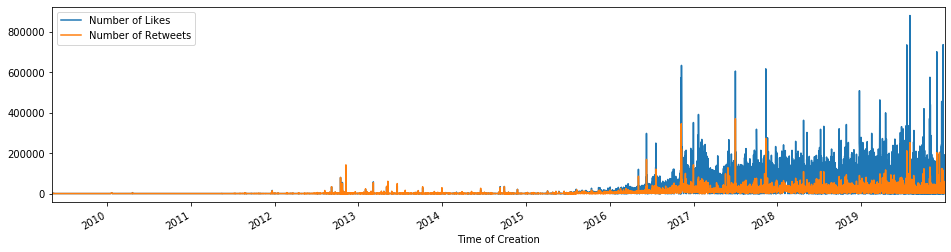

In [14]:
# %matplotlib inline will make your plot outputs appear and be stored within the notebook
%matplotlib inline
time_like.plot(figsize=(16,4), label="Number of Likes", legend=True) 
time_retweet.plot(figsize=(16,4), label="Number of Retweets", legend=True).set_xlabel("Time of Creation");

## What does his language style look like? 

### Word Cloud

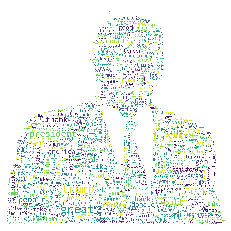

In [20]:
from wordcloud import WordCloud
from matplotlib.pyplot import imread
import matplotlib.pyplot as pt

import os 
os.chdir("D:/PhD_Journey/Y2/2020_Spring/pols559") # make sure to save the image under the folder "img" of your directory 
# we will delete the retweets for analysis
df_own = df[~df.is_retweet].copy() # we use .copy() because we don't want to change the initial data frame 
tokens_own = complete_tokens(tokenize_tweets(df_own[df_own.created_at == '2019'])) # to run it faster, let's take a look at one year for now

# we can do something fancier by adding a background picture (https://publicdomainpictures.net/en/index.php)
pic = imread('img/trump.jpg')
wc = WordCloud(background_color="white",
               stopwords=stop,
               mask=pic,
               scale=3,
               max_words=2000,
               max_font_size=100, 
               random_state=40).generate_from_frequencies(FreqDist(tokens_own))
pt.imshow(wc)
pt.axis("off")
wc.to_file('img/trump_wordcloud.jpg')
# it looks like he uses pretty simple language and the words he often uses include "great", "thank", "people","america"...

### Sentiment Analysis

In [23]:
# we can use textblob package which assigns polarity values to the individual tweets
# here's an example: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

from textblob import TextBlob # for the installation issue, I tried installing textblob on spyder console: !pip install textblob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean tweet text by removing links, special characters using simple regex statements.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def get_tweet_sentiment(tweet):
    ''' 
    Utility function to classify sentiment of passed tweet using textblob's sentiment method 
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment'] = [get_tweet_sentiment(t) for t in df.text]

In [24]:
# compare these type of tweets 
p_tweets = df[(~df.is_retweet) & (df.sentiment == 'Positive')] 
neu_tweets = df[(~df.is_retweet) & (df.sentiment == 'Neutral')]                                                                   
neg_tweets = df[(~df.is_retweet) & (df.sentiment == 'Negative')]  

In [37]:
# let's take a closer look at each type of tweets 
p_tweets.text[0:5]

0    From Donald Trump: Wishing everyone a wonderfu...
2    Wishing you and yours a very Happy and Bountif...
3    Donald Trump Partners with TV1 on New Reality ...
4    --Work has begun, ahead of schedule, to build ...
5    --From Donald Trump: "Ivanka and Jared’s weddi...
Name: text, dtype: object

In [38]:
neu_tweets.text[0:5]

1     Trump International Tower in Chicago ranked 6t...
6     Hear Donald Trump discuss big gov spending, ba...
7     Watch video of Ivanka Trump sharing business a...
9     "A lot of people have imagination, but can't e...
12    - Donald Trump bids to buy the Oreo Double Stu...
Name: text, dtype: object

In [39]:
neg_tweets.text[0:5]

11    - More hysterical DSRL videos featuring Donald...
15    -- Watch Donald Trump's recent appearance on T...
22    "Be aware of things that seem inexplicable bec...
43    "...these days...we could all use a little of ...
68    Tomorrow night's episode of The Apprentice del...
Name: text, dtype: object

In [40]:
print(f"The percentage of positive tweets is {round(len(p_tweets)*100/len(df[(~df.is_retweet)]),2)}%.")
print(f"The percentage of neutral tweets is {round(len(neu_tweets)*100/len(df[(~df.is_retweet)]),2)}%.")
print(f"The percentage of negative tweets is {round(len(neg_tweets)*100/len(df[(~df.is_retweet)]),2)}%.")

The percentage of positive tweets is 55.53%.
The percentage of neutral tweets is 26.53%.
The percentage of negative tweets is 17.95%.
